In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
merged_df = pd.read_csv('merged.csv')

In [7]:
merged_df.head()

,Unnamed: 0,Date,XOM-Price,XOM-Yield,TSLA-Price,TSLA-Yield,LLY-Price,LLY-Yield,AAPL-Price,AAPL-Yield,...,Govt_Yield,XOM-spread,TSLA-spread,LLY-spread,AAPL-spread,NVDA-spread,JPM-spread,AMZN-spread,V-spread,UNH-spread
0,0,2019-01-02,96.727,3.299,69.879,11.403,96.732,3.320,100.954,3.253,...,2.633,0.666,8.770,0.687,0.620,1.248,1.467,0.645,0.712,0.804
1,1,2019-01-03,97.207,3.212,70.389,11.270,96.941,3.283,101.039,3.236,...,2.552,0.660,8.718,0.731,0.684,1.281,1.519,0.686,0.757,0.788
2,2,2019-01-04,96.661,3.312,71.510,10.967,96.669,3.332,100.570,3.332,...,2.668,0.644,8.299,0.664,0.664,1.274,1.447,0.667,0.737,0.770
3,3,2019-01-07,96.522,3.338,73.343,10.482,96.387,3.383,100.582,3.329,...,2.698,0.640,7.784,0.685,0.631,1.239,1.398,0.648,0.697,0.753
4,4,2019-01-08,96.228,3.393,74.650,10.145,96.293,3.400,100.506,3.345,...,2.730,0.663,7.415,0.670,0.615,1.216,1.361,0.650,0.691,0.724


In [8]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df.set_index('Date', inplace=True)

# Ensure that 'Govt_Yield' and all other financial columns are in float format
financial_cols = [col for col in merged_df.columns if 'Price' in col or 'Yield' in col]
merged_df[financial_cols] = merged_df[financial_cols].astype(float)

# Find all unique companies from the 'Price' columns
companies = set(col.split('-')[0] for col in merged_df.columns if 'Price' in col)

In [9]:
# Calculate the short-term and long-term Simple Moving Averages (SMAs) for the yield spreads
def calculate_smas(data, short_window=10, long_window=50):
    for company in companies:
        spread_col = f'{company}-Yield'  # Adjusted to match provided data
        # Check if the spread column exists, if not, create by subtracting 'Govt_Yield'
        if f'{company}-spread' not in data.columns:
            data[f'{company}-spread'] = data[f'{company}-Yield'] - data['Govt_Yield']
        # Calculate SMAs
        data[f'{company}-SMA_{short_window}'] = data[spread_col].rolling(window=short_window).mean()
        data[f'{company}-SMA_{long_window}'] = data[spread_col].rolling(window=long_window).mean()

# Call the SMA calculation function
calculate_smas(merged_df)

In [12]:
# Backtesting Function
def backtest_strategy_with_interest(data, initial_investment=10000):
    cash = initial_investment
    holdings = {company: 0 for company in companies}
    portfolio_values = []  

    for date, row in data.iterrows():
        for company in companies:
            price_col = f'{company}-Price'
            yield_col = f'{company}-Yield'
            sma_short = f'{company}-SMA_10'
            sma_long = f'{company}-SMA_50'

            # Check for a crossover and adjust holdings accordingly
            if row[sma_short] > row[sma_long] and cash >= row[price_col]:
                # Buy one bond
                holdings[company] += 1
                cash -= row[price_col]
            elif row[sma_short] < row[sma_long] and holdings[company] > 0:
                # Sell one bond
                holdings[company] -= 1
                cash += row[price_col]

        # Calculate the daily portfolio value
        daily_portfolio_value = cash + sum(holdings[company] * row[price_col] for company in companies)
        portfolio_values.append(daily_portfolio_value)

    portfolio_value_df = pd.DataFrame(portfolio_values, index=data.index, columns=['Portfolio Value'])
    
    return portfolio_value_df, holdings, cash

# Perform the backtest starting from 5 years ago
start_date = merged_df.index.max() - pd.DateOffset(years=5)
backtest_data = merged_df.loc[start_date:]
portfolio_value_df, holdings, cash = backtest_strategy_with_interest(backtest_data)

# Benchmarking against equal amount invested in each bond with yearly interest payouts
def calculate_benchmark_portfolio(data, initial_investment=10000):
    investment_per_bond = initial_investment / len(companies)
    yearly_interest = {company: 0 for company in companies}
    portfolio_values = []

    for date, row in data.iterrows():
        # Check if it's the start of the year to reset the interest calculation
        if date.month == 1 and date.day == 1:
            for company in companies:
                price_col = f'{company}-Price'
                yield_col = f'{company}-Yield'
                yearly_interest[company] = (row[yield_col] / 100) * row[price_col]

        # Calculate the daily portfolio value considering the yearly interest payout
        daily_portfolio_value = sum(investment_per_bond + yearly_interest[company] for company in companies)
        portfolio_values.append(daily_portfolio_value)

    benchmark_portfolio_df = pd.DataFrame(portfolio_values, index=data.index, columns=['Benchmark Portfolio'])
    return benchmark_portfolio_df

benchmark_portfolio_df = calculate_benchmark_portfolio(backtest_data)

# Combine the backtest portfolio and benchmark portfolio
combined_portfolio_df = pd.concat([portfolio_value_df, benchmark_portfolio_df], axis=1)

combined_portfolio_df.head(), holdings, cash

(            Portfolio Value  Benchmark Portfolio
 Date                                            
 2019-04-05        10028.135              10000.0
 2019-04-08        10055.150              10000.0
 2019-04-09        10082.577              10000.0
 2019-04-10        10109.450              10000.0
 2019-04-11        10135.393              10000.0,
 {'NVDA': 16,
  'XOM': 13,
  'AAPL': 3,
  'AMZN': 13,
  'TSLA': 0,
  'LLY': 26,
  'V': 13,
  'UNH': 14,
  'JPM': 6},
 77.99200000000064)

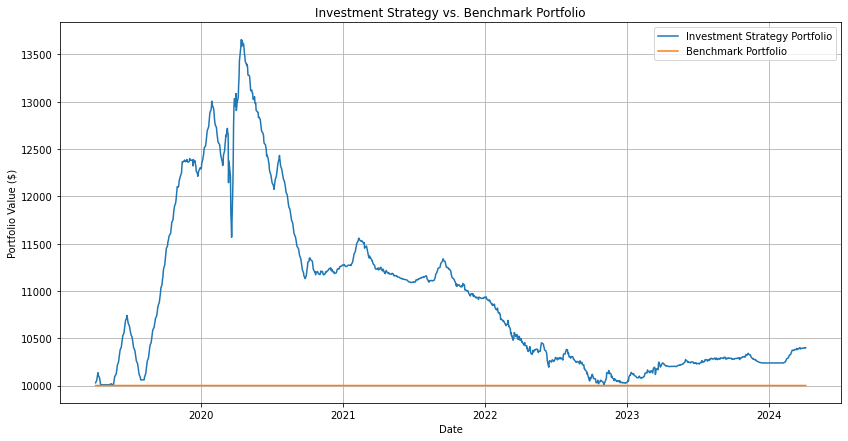

{'NVDA': 16, 'XOM': 13, 'AAPL': 3, 'AMZN': 13, 'TSLA': 0, 'LLY': 26, 'V': 13, 'UNH': 14, 'JPM': 6}
77.99200000000064


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load merged data
merged_df = pd.read_csv('merged.csv', parse_dates=['Date'])
merged_df.set_index('Date', inplace=True)

# Make sure all financial data is float
financial_cols = [col for col in merged_df.columns if 'Price' in col or 'Yield' in col]
merged_df[financial_cols] = merged_df[financial_cols].astype(float)

# Calculate SMAs for each company's spread
companies = set(col.split('-')[0] for col in merged_df.columns if 'Price' in col)
calculate_smas(merged_df)

# Backtest the strategy starting from 5 years ago
start_date = merged_df.index.max() - pd.DateOffset(years=5)
backtest_data = merged_df.loc[start_date:]
portfolio_value_df, holdings, cash = backtest_strategy_with_interest(backtest_data)

# Calculate the benchmark portfolio
benchmark_portfolio_df = calculate_benchmark_portfolio(backtest_data)

# Combine the backtest portfolio and benchmark portfolio
combined_portfolio_df = pd.concat([portfolio_value_df, benchmark_portfolio_df], axis=1)

# Plotting the comparison
plt.figure(figsize=(14, 7))
plt.plot(combined_portfolio_df.index, combined_portfolio_df['Portfolio Value'], label='Investment Strategy Portfolio')
plt.plot(combined_portfolio_df.index, combined_portfolio_df['Benchmark Portfolio'], label='Benchmark Portfolio')
plt.title('Investment Strategy vs. Benchmark Portfolio')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# Print final holdings and cash
print(holdings)
print(cash)
